In [2]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [26]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")
# 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

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [27]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. In Albany, Eric built winning coalitions to advance New York City’s values and goals, helping to push through measures to protect tenants and workers, combat gun violence, end the NYPD’s abuses of stop and frisk, and advance human rights — including marriage equality. NYC is a trademark and service mark of the City of New York.


In [28]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [29]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [30]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_anMpuV4OsCELlB7l3vyP9H14)
 Call ID: call_anMpuV4OsCELlB7l3vyP9H14
  Args:
    query: current mayor of New York City
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nyc.gov/office-of-the-mayor/bio.page", "title": "Office of the Mayor | Mayor's Bio | City of New York - NYC.gov", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City", "score": 0.82048416, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/Eric_Adams", "title": "Eric Adams - Wikipedia", "content": "Eric

In [31]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [32]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_Qs9urQ0g78CFpHUJkZdyGFn4)
 Call ID: call_Qs9urQ0g78CFpHUJkZdyGFn4
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_YQOuOJEurkxeaPTxxto5miwa)
 Call ID: call_YQOuOJEurkxeaPTxxto5miwa
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




In [43]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

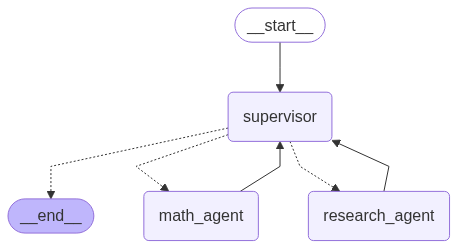

In [44]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [45]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

In 2024, the estimated US GDP was $28.7 trillion, and New York State's GDP was $2.297 trillion. New York State accounted for approximately 8.0% of the total US GDP in 2024.




In [46]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,  
            update={**state, "messages": state["messages"] + [tool_message]},  
            graph=Command.PARENT,  
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

In [47]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

In [48]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

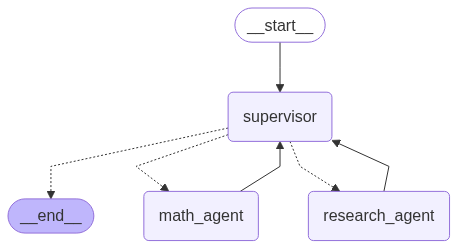

In [49]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [50]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

- US GDP in 2024: $29.18 trillion (source: Statista, https://www.statista.com/statistics/263591/gross-domestic-product-gdp-of-the-united-states/)
- New York state GDP in 2024: $2.297 trillion (source: Wikipedia, https://en.wikipedia.org/wiki/Economy_of_New_York_(state))

New York state's GDP as a percentage of US GDP in 2024: approximately 7.87%.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================== Ai Message ==================================
Name: math_agent

US GDP 

In [51]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

find US and New York state GDP in 2024. what % of US GDP was New York state?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (call_wPKsiezNHMzyGvpEgosJfQlr)
 Call ID: call_wPKsiezNHMzyGvpEgosJfQlr
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_EUJLqAMEj7LenKsHb6ZzgTwB)
 Call ID: call_EUJLqAMEj7LenKsHb6ZzgTwB
  Args:
    query: US GDP in 2024
    search_depth: advanced
  tavily_search (call_N5bVj11KO3orBSCGO6N9znrm)
 Call ID: call_N5bVj11KO3orBSCGO6N9znrm
  Args:
    query: New York state GDP in 2024
    search_depth: advanced
================================= Tool M

In [52]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

In [53]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (call_CFb5KRbi1RvAh1JbL1GrlyDq)
	 Call ID: call_CFb5KRbi1RvAh1JbL1GrlyDq
	  Args:
	    task_description: Find the most recent estimates or forecasts for the US GDP and New York State GDP for the year 2024. Ensure reliable sources are used (e.g., government databases, reputable economic forecasts).


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_f9JeETG2mtXi83oGKAHiNpm4)
	 Call ID: call_f9JeETG2mtXi83oGKAHiNpm4
	  Args:
	    query: most recent 2024 US GDP forecast or estimate
	    search_depth: advanced
	  tavily_search (call_QswUei9NmgykZ7kfDL98wwNw)
	 Call ID: call_QswUei9NmgykZ7kfDL98wwNw
	  Args:
	    query: most recent 2024